In [4]:
import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [5]:
yf.pdr_override()
df = pdr.get_data_yahoo("NKD=F", start="2015-01-01", end="2023-04-06")
#df = pd.DataFrame(data = df, columns=['Open','High', 'Low','Close','Adj Close','Volume'])
if isinstance(df, pd.DataFrame):
    df.head()

[*********************100%***********************]  1 of 1 completed


In [3]:
df.to_csv("Price_NKDF.csv")

In [7]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-30,27885.0,28040.0,27690.0,28000.0,28000.0,3008
2023-03-31,28010.0,28305.0,27995.0,28270.0,28270.0,3210
2023-04-03,28240.0,28340.0,28110.0,28270.0,28270.0,2273
2023-04-04,28255.0,28390.0,28075.0,28155.0,28155.0,2592
2023-04-05,28170.0,28210.0,27635.0,27760.0,27760.0,2592


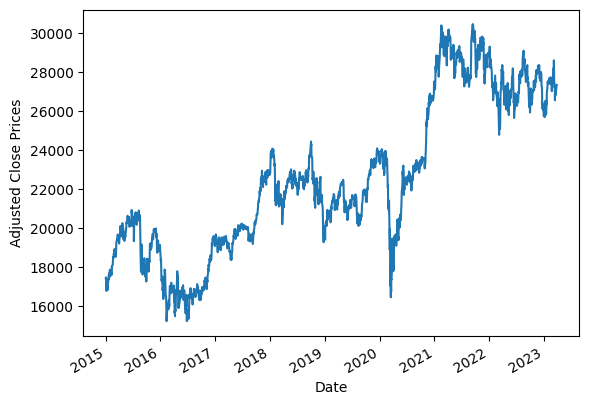

In [4]:
df['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

In [20]:
df.dropna(inplace=True)

In [21]:
x = df.iloc[:, 0:5].values
y = df.iloc[:, 4].values
x.shape
y.shape

(306,)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26,  random_state=0)

In [23]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 1, 'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 9, 'bootstrap': True}


In [26]:
model = RandomForestRegressor(n_estimators=500, random_state=1, min_samples_split=2, min_samples_leaf=1, max_depth=9, bootstrap=True)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[27637.94       27033.72       26241.28533333 27322.692
 28485.16       26948.84       28350.81       26855.03916667
 27454.917      26251.6        28241.55       26295.22783333
 27772.21       25751.42666667 27995.73916667 27681.01
 27794.27       25815.06       28368.36       27155.02
 27838.74       28830.42       27665.15       27524.32707143
 28208.189      26687.96       26190.28       27772.05
 27563.8        26501.61333333 26999.94       25824.30666667
 27197.96       29001.79       27154.92       27093.986
 27995.97566667 27580.93       28045.40390476 26571.1
 26357.31375    28367.16       27027.07       27881.385
 27097.21       27196.09       27493.52214286 27140.2
 26729.82       28232.824      28134.728      26757.5975
 26945.62       26669.66       26066.62       28905.35
 27462.20464286 26504.62       28689.93       25298.54
 26891.99       27443.63666667 26240.72333333 26621.27
 27210.78       27561.25       29001.85       26690.58
 28037.46457143 28107.315      27235.0

In [27]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 12.6577
Mean Squared Error: 617.0486
Root Mean Squared Error: 24.8405
(R^2) Score: 0.9991
Train Score : 99.95% and Test Score : 99.91% using Random Tree Regressor.
Accuracy: 99.95 %.


In [28]:
predictions = pd.DataFrame({"Predictions": predict}, index=pd.date_range(start=df.index[-1], periods=len(predict), freq="D"))
predictions.to_csv("Predicted-price-data.csv")
#colllects future days from predicted values
oneyear_df = pd.DataFrame(predictions[:252])
oneyear_df.to_csv("one-year-predictions.csv")
onemonth_df = pd.DataFrame(predictions[:21])
onemonth_df.to_csv("one-month-predictions.csv")
fivedays_df = pd.DataFrame(predictions[:5])
fivedays_df.to_csv("five-days-predictions.csv")

Buy price and date
    Unnamed: 0   Predictions
13  2023-04-03  25751.426667
13    25751.426667
Name: Predictions, dtype: float64
Sell price and date
4    28485.16
Name: Predictions, dtype: float64


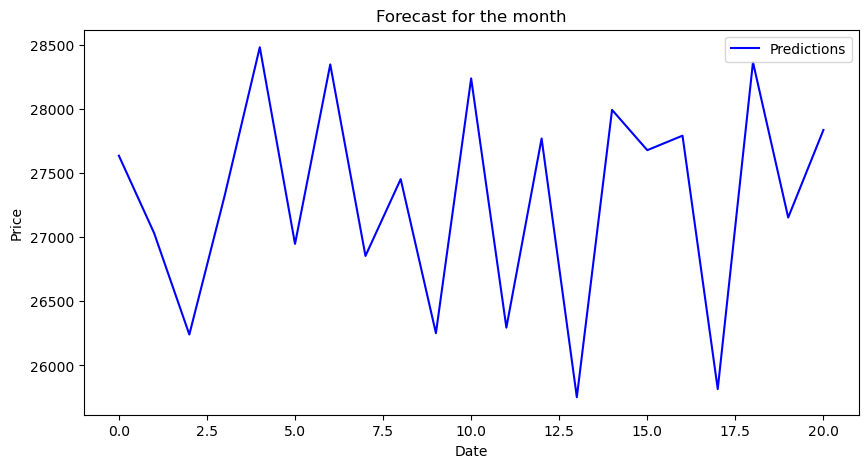

In [29]:
onemonth_df_pred = pd.read_csv("one-month-predictions.csv")
buy_price = min(onemonth_df_pred["Predictions"])
sell_price = max(onemonth_df_pred["Predictions"])
onemonth_buy = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == buy_price]
onemonth_sell = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(onemonth_buy)
print(onemonth_buy.loc[:, 'Predictions'])
print("Sell price and date")
print(onemonth_sell.loc[:, 'Predictions'])
onemonth_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the month", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()